1 Quick Dogs v Cats

In [1]:
# git pull https://github.com/fastai.git
# cd fastai
# conda env create -f environment.yml
# source activate fastai
# python -m ipykernel install --user --name fastai --display-name "Python 3 (FastAI)"

# ## if working from another dir:
# ln -s <path to fastai/fastai> fastai

In [2]:
# %mkdir -p data/dogscats

In [1]:
from fastai.conv_learner import * # conv_learner p.much imports everything else
PATH = 'data/dogscats/'
sz=224; bs=16

In [2]:
# how do we want to tsfm our data: in a way that's suitable to the resnet50 model
# assuming the photos are side-on photos, and zooming in up to 10% ea. time
tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# we want to get some data in from paths (assuming there's a folder for ea. class inside 
# train/ and valid/ -- to submit to Kaggle need specfy test/ folder
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
# create a model from a pretrained resnet50 model using data
learn = ConvLearner.pretrained(resnet50, data)
# call fit; be default has all but last few layers frozen
# here we do 3 cycles of len 1
%time learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.05118  0.02872  0.991  ]                           
[ 1.       0.05651  0.02752  0.9915 ]                           
[ 2.       0.04177  0.02755  0.9915 ]                           

CPU times: user 13min 59s, sys: 6min 44s, total: 20min 43s
Wall time: 20min 44s


We didn't specify `precompute=True` because it only makes it a little faster for this first set. So we skipped it. It's a shortcut that caches some of the intermediate steps that don't have to be recalculated each time. **NOTE**: when we use precomputed activations: data augmentation will not work.

So if you specfy data augmentation, such as w/ `aug_tfms=...`, and also `precompute=True` `fastai` will not actually do any data augmentation.

**NOTE:** if you're using big / deep model like ResNet50 or ResNeXt101 on a dataset v.similar to ImageNet (like this cats/dogs datset; ie: side-on photos of standard objects of a similar size to ImageNet: 200~500 pxls), you should probably run `learn.bn_freeze(True)` after `learn.unfreeze()`.

What this is doing is causing the BatchNorm moving averages to stop updating.

(Not currently supported by any library besides fastai, and is v.important)

*Needed to restart kernel & set batch-size to 16 to fit it in Gfx Memory
rerun lines: `tfms = ...; data = ...; learn = ...;`*

We run one more epoch, training the entire network:

In [3]:
# we can unfreeze and this will train the entire network
learn.unfreeze()
# bn_freeze stops updates of 
learn.bn_freeze(True) # important for large models --> stops updates of BN moving avgs
                      # use for models w/ ~ > 34 layers, & larger imgs & reg.s of intrst & norml imgs
%time learn.fit([1e-5, 1e-4, 1e-2], 1, cycle_len=1)

A Jupyter Widget

[ 0.       0.02448  0.02461  0.9915 ]                           

CPU times: user 13min 16s, sys: 9min 18s, total: 22min 34s
Wall time: 22min 33s


In [18]:
# We use Test Time Augmentation to ensure we get the best predictions we can
%time log_preds, y = learn.TTA()

# Finally, this gives us about 99.6% accuracy
metrics.log_loss(y, np.exp(log_preds)), accuracy(log_preds, y)

CPU times: user 1min 48s, sys: 54.2 s, total: 2min 42s
Wall time: 2min 44s


(0.01387910053572471, 0.99650000000000005)

That's great, I think that's tested on a validation set? (https://youtu.be/_VpaKaMyjqI?t=2772 : Yes.) Now to run predictions on the actual test data set.

These were all essentially the minimum set of steps when you try a new dataset. This assumes we already know what learning rate to use (use the learning-rate finder to decide on that), and knowing the directory layout, & etc.

**NOTE:** Don't forget to save your weights! (I think) specifying a new learner and data object will load the pretrained model from scratch.

In [5]:
learn.save('ResNet50_01')

Up above, `TTA()` has `is_test` set to False by default, so it won't use the test set. *Iguess it uses the valid set?* To use the test set, specify `is_test=True`

**NOTE:** running `TTA()` on the test set wasn't working `('NoneType' TypeError)` because the `test_name` par to `from_paths(..)` is by default set to None. Also the test dir in this dataset (from fast.ai) is called `test1/`, so has to be specfd as such or renamed.

In [7]:
# Reloading saved weights after re-openning notebook;
# Also specifying test dataset for final predictions:
tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, test_name='test1')
learn = ConvLearner.pretrained(resnet50, data)
learn.load('ResNet50_01')

In [9]:
%time log_preds, y = learn.TTA(is_test=True)

CPU times: user 11min 16s, sys: 5min 31s, total: 16min 48s
Wall time: 16min 51s


In [11]:
test_preds = np.exp(log_preds)

In [12]:
len(test_preds)

12500

In [ ]:
# id,label
# 1,0.5
# 2,0.5

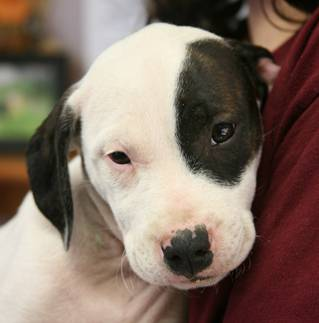

In [55]:
data.test_ds.get_x(0)

In [17]:
test_preds[:10]

array([[ 0.00001,  0.99999],
       [ 0.00025,  0.99946],
       [ 0.00012,  0.99954],
       [ 0.     ,  1.     ],
       [ 0.00022,  0.99945],
       [ 1.     ,  0.     ],
       [ 0.99999,  0.     ],
       [ 0.00002,  0.99998],
       [ 1.     ,  0.     ],
       [ 0.00003,  0.99995]], dtype=float32)

### One way to create the submission csv file:

In [32]:
# See: http://forums.fast.ai/t/dog-breed-identification-challenge/7464/101
ids = [i.split('.jpg')[0].split('/')[-1] for i in data.test_dl.dataset.fnames]

In [36]:
preds = [np.argmax(pred) for pred in test_preds]

In [37]:
preds[:10]d

[1, 1, 1, 1, 1, 0, 0, 1, 0, 1]

In [38]:
submission = pd.DataFrame()
submission['id'] = [i for i in ids]
submission['label'] = [p for p in preds]

In [39]:
submission.head()

,id,label
0,9323,1
1,10291,1
2,7641,1
3,10707,1
4,9769,1


### Another way to create the submission csv file:

In [73]:
df = pd.DataFrame(test_preds)
df.columns = data.classes

In [74]:
# '6:' skips the 'test1/' part of the fname, ':-4' skips the '.jpg' part
df.insert(0, 'id', [o[6:-4] for o in data.test_ds.fnames])

In [75]:
df.head()

,id,cats,dogs
0,9323,1.220739e-05,0.999987
1,10291,2.481641e-04,0.999458
2,7641,1.200634e-04,0.999539
3,10707,6.460466e-08,1.000000
4,9769,2.245708e-04,0.999445


**NOTE:** THIS WILL ***NOT*** WORK FOR THIS DATASET. Only because I'm lazy. The format for this datset's submissions is: 
>`id,label`

>`<id_num>,<0 or 1>`

>`...,...`

But this 2nd method is generally how you'll go about it for multi-class data; and even this datset if you make sure the format is correct.

### Saving the CSV File & Submitting

In [41]:
os.mkdir(PATH + '/results/')

In [82]:
%ls $PATH

models/  results/  sample/  test1/  tmp/  train/  valid/


In [53]:
submission.to_csv(PATH+'results/' + 'submission_dogscats_quick_00.csv')

In [88]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
# df.to_csv(f'{PATH}subm.gz', compression='gzip', index=False)
submission.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [89]:
FileLink(f'{SUBM}subm.gz')

/home/wnixalo/Kaukasos/FADL1/data/dogscats/subm/subm.gz

#### Misc; looking at stuff

In [90]:
submission.head()

,id,label
0,9323,1
1,10291,1
2,7641,1
3,10707,1
4,9769,1


In [54]:
data.classes

['cats', 'dogs']

In [57]:
# 1st 10 filenames in test dataset: (I fucking love fastai)
data.test_ds.fnames[:10]

['test1/9323.jpg',
 'test1/10291.jpg',
 'test1/7641.jpg',
 'test1/10707.jpg',
 'test1/9769.jpg',
 'test1/4283.jpg',
 'test1/9966.jpg',
 'test1/6870.jpg',
 'test1/6680.jpg',
 'test1/744.jpg']